###  Created by Luis Alejandro (alejand@umich.edu)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from utils import unicode_to_ascii
from dataset import DatasetBuilder
from attention_translation import preprocess
from attention_translation import Translator
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
# GPU?
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def plot_attention(attention, source, target, builder):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + [builder.source_tokenizer.index_to_word[word].decode() for word in source],rotation=90)
    ax.set_yticklabels([''] + [builder.target_tokenizer.index_to_word[word].decode() for word in target])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [4]:
# Creates dataset for training
files = ['../../datasets/nlp/english-spanish.txt']
builder = DatasetBuilder(files, preprocessors=(preprocess,preprocess), batch_size=64, max_obs=30000, test_obs=20)
train_dataset, test_dataset = builder.build()

In [5]:
# Defining model
translator = Translator(builder.source_tokenizer.word_to_index,
                        builder.target_tokenizer.word_to_index,
                        source_embedding_size=256,
                        target_embedding_size=256,
                        max_output_length=builder.target_tokenizer.max_seq,
                        attention_size=512,
                        restore=True)

In [6]:
# Training model
translator.train(5, train_dataset, test_dataset)

Epoch 1 out of 5 complete (69.96 secs) -- Train Loss: 0.2714 -- Train Acc: 0.94 -- Test Loss: 0.1571 -- Test Acc: 0.96
Epoch 2 out of 5 complete (34.50 secs) -- Train Loss: 0.1843 -- Train Acc: 0.95 -- Test Loss: 0.1641 -- Test Acc: 0.95
Epoch 3 out of 5 complete (34.83 secs) -- Train Loss: 0.1677 -- Train Acc: 0.96 -- Test Loss: 0.1663 -- Test Acc: 0.94
Epoch 4 out of 5 complete (34.89 secs) -- Train Loss: 0.1554 -- Train Acc: 0.96 -- Test Loss: 0.1692 -- Test Acc: 0.96
Epoch 5 out of 5 complete (35.22 secs) -- Train Loss: 0.1448 -- Train Acc: 0.96 -- Test Loss: 0.1862 -- Test Acc: 0.95
Creating final checkpoint!


In [15]:
# Creating some input
source = b"I'm very happy to see you."
source = preprocess(tf.constant(source))
source = tf.strings.split(tf.constant(source))
print(source)
source = builder.source_tokenizer.encode(source.numpy())
source = tf.constant(np.pad(source, (0, builder.source_tokenizer.max_seq - len(source))),
                     shape=[1, builder.source_tokenizer.max_seq])
print(source)

tf.Tensor([b'<start>' b'i' b'm' b'very' b'happy' b'to' b'see' b'you' b'.' b'<end>'], shape=(10,), dtype=string)
tf.Tensor([[  0  17  49 946 295 255 104 105   2   3   0]], shape=(1, 11), dtype=int32)


estoy muy sin verte . <end>


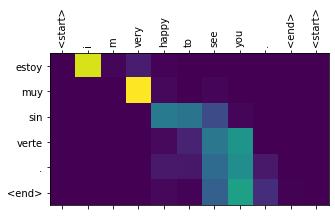

In [16]:
# Outputing model translation
prediction, attention = translator.translate(source, return_attention=True)
print(' '.join(builder.target_tokenizer.index_to_word[word].decode() for word in prediction))
plot_attention(attention, tf.squeeze(source).numpy(), prediction, builder)

Expected: tenemos algunos .
(5, 11)
Translation: tenemos unos cuantos . <end>



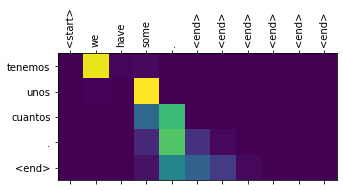

Expected: aquellos son de tom .
(6, 11)
Translation: esos son de tom . <end>



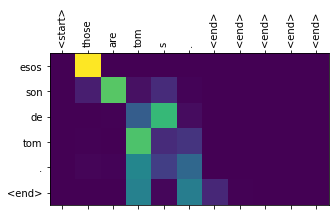

Expected: el es dj .
(5, 11)
Translation: el es dj . <end>



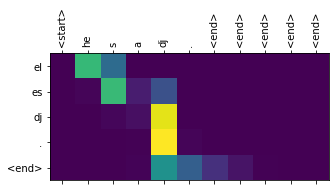

Expected: tom no cedera .
(5, 11)
Translation: tom no cedera . <end>



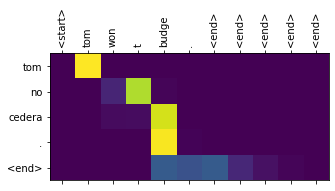

Expected: tom me da asco .
(8, 11)
Translation: tom me da a la misma . <end>



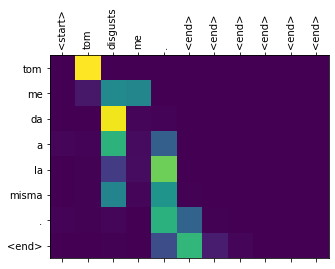

Expected: deja que responda tom .
(6, 11)
Translation: deja que tom diga . <end>



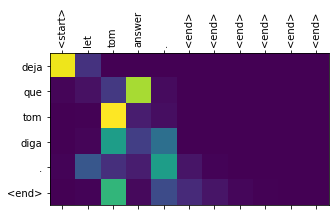

Expected: estas triste .
(4, 11)
Translation: estas triste . <end>



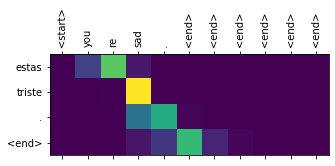

Expected: ataca !
(3, 11)
Translation: ataque ! <end>



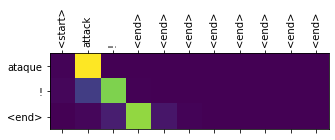

Expected: conocemos el porque .
(5, 11)
Translation: sabemos por que . <end>



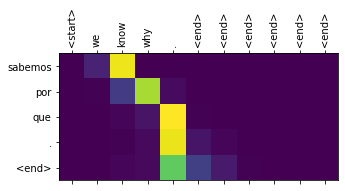

Expected: dame la llave .
(5, 11)
Translation: dame la llave . <end>



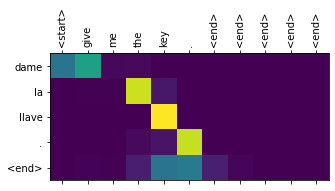

Expected: consigueme un abogado .
(5, 11)
Translation: traeme un abogado . <end>



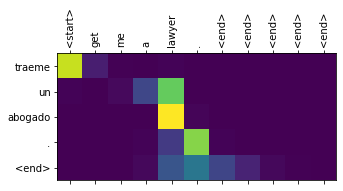

Expected: puede hacerse .
(5, 11)
Translation: puede ser posible . <end>



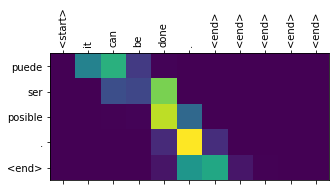

Expected: tom obedecio a mary .
(6, 11)
Translation: tom obedecio a mary . <end>



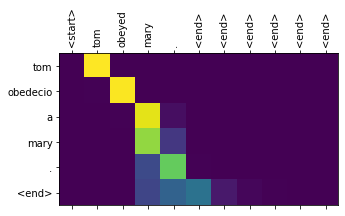

Expected: no te entrometas .
(5, 11)
Translation: deja de molestarme . <end>



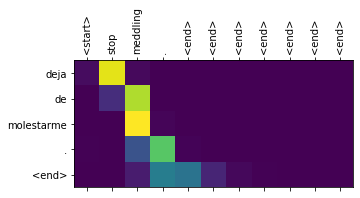

Expected: ¿ la conoces a ella ?
(5, 11)
Translation: ¿ la conoceis ? <end>



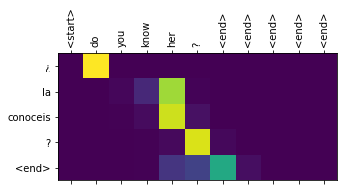

Expected: estoy confundida .
(4, 11)
Translation: estoy confundida . <end>



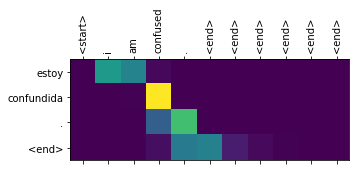

Expected: cogelo .
(3, 11)
Translation: agarralo . <end>



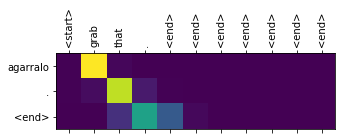

Expected: esta bien llorar .
(5, 11)
Translation: esta bien llorar . <end>



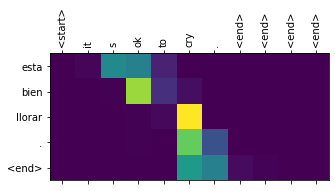

Expected: se esta fresquito .
(4, 11)
Translation: hace fresco . <end>



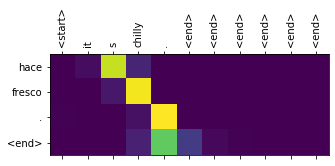

Expected: odio bailar .
(4, 11)
Translation: odio bailar . <end>



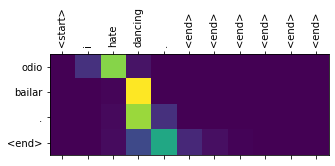

In [9]:
# Check translation for elements in test set
for batch in test_dataset:
    for source, target in zip(batch[0], batch[1]):
        # Prepares input
        source = tf.expand_dims(source,0)
        # Prints expected translation
        words = []
        for word in target.numpy():
            decoded = builder.target_tokenizer.index_to_word[word].decode()
            words.append(decoded)
            if decoded == '<end>':
                break
        print('Expected:', ' '.join(words[1:-1]))
        # Prints actual translation
        words = []
        prediction, attention = translator.translate(source, return_attention=True)
        print(attention.shape)
        for word in prediction:
            decoded = builder.target_tokenizer.index_to_word[word].decode()
            words.append(decoded)
        print('Translation:', ' '.join(words), end='\n\n')
        # Plots attention
        plot_attention(attention, tf.squeeze(source).numpy(), prediction, builder)